In [1]:
import requests
import json
import matplotlib
import re
import pydot
from graphviz import Digraph
from graphviz import Source
from baseline_4lang import Utils
from baseline_utils import process_baseline
from nltk.corpus import stopwords
import pprint
from Levenshtein import distance

In [2]:
import networkx as nx
from networkx.readwrite import json_graph
from collections import defaultdict
utils = Utils()

In [ ]:
dictionary = defaultdict(list)
with open("/home/adaamko/tools/wikt2dict/dat/wiktionary/Hungarian/dictionary", "r+") as f:
    for line in f:
        line = line.strip().split("\t")
        if line[0] == "en":
            dictionary[line[1].lower()].append(line[3].lower())

In [ ]:
from collections import defaultdict
dictionary_hok = defaultdict(list)
count=0
with open("/home/adaamko/data/hokoto", errors="replace") as f:
    for line in f:
        line = line.strip().split("@")
        if count<33:
            print(line)
        count+=1
        dictionary_hok[line[0].lower()].append(line[2].lower())
        
old_char = ["a1", "e1", "u1", "i1", "o1", "A1", "E1", "U1", "I1", "O1", "o2", "u2", "O2", "U2", "o3", "u3", "O3", "U3", "_"]
new_char = ["á", "é", "ú", "í", "ó", "Á", "É", "Ú", "Í", "Ó", "ö", "ü", "Ö", "Ü", "ő", "ű", "Ő", "Ű", " "]

for i in dictionary_hok:
    for j in range(len(dictionary_hok[i])):
        for k in range(len(old_char)):
            dictionary_hok[i][j] = dictionary_hok[i][j].replace(old_char[k], new_char[k])
            
for word_hok in dictionary_hok:
    words = dictionary_hok[word_hok]
    dictionary[word_hok] += words

In [ ]:
fourlang_en = defaultdict(list)
fourlang_hu = defaultdict(list)
with open("/home/adaamko/projects/4lang/1200.tsv") as f:
    for line in f:
        line = line.strip().split('\t')
        en = line[0].lower()
        hu = line[1].lower()
        for k in range(len(old_char)):
            hu = hu.replace(old_char[k], new_char[k])
        fourlang_en[en].append(hu)
        fourlang_hu[hu].append(en)

In [7]:
sentence = 'polga1rmester'
data = {'word':   sentence}
data_json = json.dumps(data)
payload = {'json_payload': data_json}
headers = {'Content-type': 'application/json', 'Accept': 'text/plain'}
r = requests.post("http://hlt.bme.hu/4lang/defhun", data=data_json, headers=headers)
s_machines = r.json()['word']

g_sen_en = json_graph.adjacency.adjacency_graph(s_machines)
s_dot = utils.to_dot(g_sen_en)
v_sen = Source(s_dot)

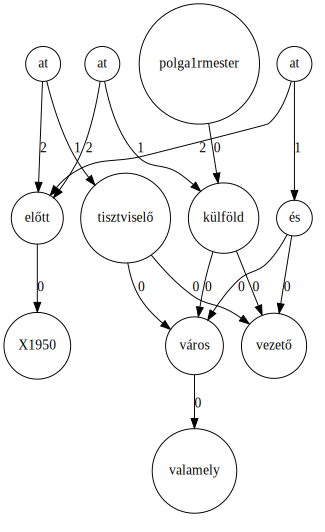

In [8]:
v_sen

In [55]:
sentence = 'this'
data = {'word':   sentence}
data_json = json.dumps(data)
payload = {'json_payload': data_json}
headers = {'Content-type': 'application/json', 'Accept': 'text/plain'}
r = requests.post("http://hlt.bme.hu/4lang/definition", data=data_json, headers=headers)
s_machines = r.json()['word']

In [56]:
g_sen_hu = json_graph.adjacency.adjacency_graph(s_machines)
s_dot = utils.to_dot(g_sen_hu)
v_sen = Source(s_dot)

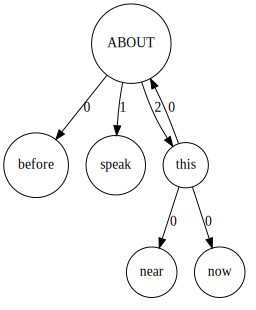

In [57]:
v_sen

In [ ]:
en_nodes = utils.get_edges(g_sen_hu)
en_nodes

In [ ]:
hu_nodes = utils.get_nodes(g_sen_hu)
hu_nodes

In [3]:
sentences = process_baseline("/home/adaamko/data/1984.sen-aligned.np-aligned.gold")
len(sentences)

6567

In [68]:
from collections import defaultdict
import spacy
import emmorphpy.emmorphpy as emmorph
import itertools
from itertools import permutations, repeat

nlp_en = spacy.load('en')
nlp_hu = emmorph.EmMorphPy()

In [ ]:
for k,sentence in enumerate(sentences):
    print(k)
    sentence['hu_sen_4lang'] = []
    sentence['en_sen_4lang'] = []
    for np in sentence['en_sen']:
        if type(np) == tuple:
            sen = ' '.join(np[1])
            data = {'sentence':   sen}
            data_json = json.dumps(data)
            payload = {'json_payload': data_json}
            headers = {'Content-type': 'application/json', 'Accept': 'text/plain'}
            r = requests.post("http://hlt.bme.hu/4lang/senexp", data=data_json, headers=headers)
            s_machines = r.json()['sentence']

            g_sen_en = json_graph.adjacency.adjacency_graph(s_machines)
            en_nodes = utils.get_nodes(g_sen_en)
            sentence["en_sen_4lang"].append((np[0], en_nodes))
    for np in sentence['hu_sen']:
        if type(np) == tuple:
            sen = ' '.join(np[1])
            data = {'sentence':   sen}
            data_json = json.dumps(data)
            payload = {'json_payload': data_json}
            headers = {'Content-type': 'application/json', 'Accept': 'text/plain'}
            r = requests.post("http://hlt.bme.hu/4lang/senexphun", data=data_json, headers=headers)
            s_machines = r.json()['sentence']
            
            g_sen_hu = json_graph.adjacency.adjacency_graph(s_machines)
            en_nodes = utils.get_nodes(g_sen_hu)
            sentence["hu_sen_4lang"].append((np[0], en_nodes))

In [ ]:
with open('sentences.json', 'w+', encoding='utf-8') as file:
     file.write(json.dumps(sentences))

In [65]:
def filter_4lang(nps, language):
    lemmas = []
    if language == "hu":
        words = [word for word in nps if word.isupper() == False]
        words = [word.lower() for word in words if word.lower() not in stopwords.words('hungarian')]
        words = [word for word in words if word not in stopwords.words('hungarian')]
        words = [word.lower() for word in words if word.lower() not in ["in", "on", "root", "at", "to", "has"]]
        if not words:
            words = nps
        for np in words:
            try:
                if len(nlp_hu.stem(np)) > 0:
                    lemma = nlp_hu.stem(np)[0][0]
                    lemmas.append(lemma)
                    lemmas.append(np)
                else:
                    lemmas.append(np)
            except (IndexError, NameError) as e:
                print(e)
                lemmas.append(np)
        
    if language == "en":
        words = [word.lower() for word in nps if word.lower() not in stopwords.words('english')]
        words = [word for word in words if word not in stopwords.words('english')]
        words = [word for word in words if word.startswith("x") == False or word.isupper() == False]
        if not words:
            words = nps
        for np in words:
            if len(nlp_en(np)) > 0:
                lemma = nlp_en(np)[0].lemma_
            else:
                lemma = np
            if lemma == "-PRON-":
                lemmas.append(np.lower())
            else:
                lemmas.append(lemma.lower())
                lemmas.append(lemma)
    return lemmas

In [70]:
def filter_nps(nps, language):
    lemmas = []
    if language == "hu":
        #words = [word for word in nps if word.isupper() == False]
        #words = [word.lower() for word in words if word.lower() not in stopwords.words('hungarian')]
        words = [word for word in nps if word not in stopwords.words('hungarian')]
        if not words:
            words = nps
        for np in words:
            try:
                if len(nlp_hu.stem(np)) > 0:
                    lemma = nlp_hu.stem(np)[0][0]
                    lemmas.append(lemma)
                    lemmas.append(np)
                else:
                    lemmas.append(np)
            except (IndexError, NameError) as e:
                print(e)
                lemmas.append(np)
        
    if language == "en":
        #words = [word.lower() for word in nps if word.lower() not in stopwords.words('english')]
        words = [word for word in nps if word not in stopwords.words('english')]
        if not words:
            words = nps
        for np in words:
            if len(nlp_en(np)) > 0:
                lemma = nlp_en(np)[0].lemma_
            else:
                lemma = np
            if lemma == "-PRON-":
                lemmas.append(np.lower())
            else:
                #lemmas.append(lemma.lower())
                lemmas.append(lemma)
    return lemmas

In [814]:
def process(sen):
    scores = compute_scores(sen, dictionary)
    if scores is None:
        return None
    aligns = []
    for i in range(len(scores)):
        for j,k in enumerate(scores[i]):
            if float(k) > 0.001:
                aligns.append((str(i), str(j)))
    return aligns

In [818]:
def compute_scores(sen, dic):
    en_nps = {}
    hu_nps = {}
    for s in sen['en_sen']:
        if type(s) == tuple:
            np_to_filter = s[1]
            if not np_to_filter:
                for np in sen['en_sen']:
                    if type(np) == tuple:
                        if np[0] == s[0]:
                            np_to_filter = np[1]
            lemmas = filter_nps(np_to_filter, "en")
            en_nps[s[0]] = lemmas
    for s in sen['hu_sen']:
        if type(s) == tuple:
            np_to_filter = s[1]
            if not np_to_filter:
                for np in sen['hu_sen']:
                    if type(np) == tuple:
                        if np[0] == s[0]:
                            np_to_filter = np[1]
            lemmas = filter_nps(np_to_filter, "hu")
            hu_nps[s[0]] = lemmas
    
            
    scores = [[] for i in range(len(en_nps))]
    

    #dic_elements = defaultdict(list)
    #for en_np in en_nps:
        #for word in en_nps[en_np]:
            #print(word)
            #for el in dictionary[word]:
                #dic_elements[word].append(el)
    pp = pprint.PrettyPrinter(indent=4)
    #pp.pprint(dic_elements)
    #pp.pprint(en_nps)
    #pp.pprint(hu_nps)
    for en_np in en_nps:
        for hu_np in hu_nps:
            l = []
            hu_lower = [s.lower() for s in hu_nps[hu_np]]
            add_morphs = []
            for low in hu_lower:
                if count_vowels(low) > 3:
                    ms = morphemes[low]
                    add_morphs += ms
            for addit in add_morphs:
                if addit not in hu_lower:
                    hu_lower.append(addit)
                            
                    
            for word in en_nps[en_np]:
                dic_elements = []
                w = word.strip("-").lower()
                if not dictionary[w]:
                    dic_elements.append(w)
                for el in dictionary[w]:
                     #for i in el.split():
                    dic_elements.append(el)
                inter = []
                for en_word in dic_elements:
                    for hu_word in hu_lower:
                        dis = distance(en_word, hu_word)
                        
                        if(len(en_word) > 5 or len(hu_word) > 5):
                            if dis < 3:
                                inter.append(True)
                        else:
                            if dis < 1:
                                inter.append(True)
                if len(inter) > 0:
                    l.append(True)
                else:
                    ancestors_word_en = []
                    for anc in en_ancestors[word]:
                        if anc not in en_ancestor_top:
                            ancestors_word_en.append(anc)
                    ancestors_word_en.append(word)
                    
                    ancestors_word_hu = []
                    for hu_word in hu_lower:
                        ancestors_word_hu.append(hu_word)
                        for anc in hu_ancestors[hu_word]:
                            if anc not in hu_ancestor_top:
                                ancestors_word_hu.append(anc)
                    for word_en in ancestors_word_en:
                        dic_elements = []
                        w = word_en.strip("-").lower() 
                        if w in stopwords.words("english"):
                            pass
                        else:
                            if not dictionary[w]:
                                dic_elements.append(w)
                            for el in dictionary[w]:
                                if el not in stopwords.words('hungarian'):
                                     #for i in el.split():
                                    dic_elements.append(el)
                            inter = []
                        for en_word in dic_elements:
                            for hu_word in ancestors_word_hu:
                                dis = distance(en_word, hu_word)
                                if dis < 1:
                                    inter.append(True)
                        l.append(len(inter) > 0)
            listmax = max([hu_lower, en_nps[en_np]], key=len)
            if len(l) == 0:
                score = 0
            else:
                score = float(l.count(True)/len(l))
            scores[en_np].append(score)
    return scores


In [ ]:
def return_morph(word):
    s = nlp_hu.analyze(word)
    ret_list = []
    for i in s:
        i = i.split("=")
        morpheme = i[1]
        morpheme = morpheme.split("+")
        for m in morpheme:
            mor = m.split("[")[0].strip()
            if len(mor) > 2:
                ret_list.append(m.split("[")[0].strip())
    return ret_list

In [ ]:
from collections import Counter
def count_vowels(word):
    c = {v:word.count(v) for v in 'aeuioáéúüűíóöő'}
    count = sum(c.values())
    return count

In [ ]:
#Finding the morphemes of the words
morphemes = defaultdict(list)
for k,sentence in enumerate(sentences):
    print(k)
    for np in sentence['hu_sen']:
        if type(np) == tuple:
            hu_lemmas = filter_nps(np[1], "hu")
            for word in hu_lemmas:
                if count_vowels(word) > 3:
                    m = return_morph(word)
                    if word not in morphemes:
                        morphemes[word] += m

In [ ]:
guesses = []
senaligns = {}
for sentence in sentences:
    print(sentence['id'])
    gold = sentence['aligns']
    gold_filtered = []
    for goldalign in gold:
        en = re.findall('\d+', goldalign[0] )
        hu = re.findall('\d+', goldalign[1] )
        gold_filtered.append((str(en[0]), str(hu[0])))
    al = process(sentence)
    senaligns[sentence['id']] = al
    if al is not None:        
        for i in al:
            if i in gold_filtered:
                guesses.append(True)
            else:
                guesses.append(False)

In [828]:
score = float(guesses.count(True)/len(guesses))
np_len = 0
for sen in sentences:
    np_len += len(sen['aligns'])
print(score)
print(np_len)
print(len(guesses))
recall = (score * len(guesses)) / np_len
f1_score = (2*recall*score)/(recall+score)
print(recall)
print(f1_score)

0.7405826217980914
18848
19910
0.7823111205432938
0.7608751741575933


In [ ]:
process(sentences[7])

In [93]:
hu_ancestors = defaultdict(list)
en_ancestors = defaultdict(list)

Angol ősök kigyujtese

In [61]:
def expand_en_word_all(word):
    data = {'word':   word}
    data_json = json.dumps(data)
    payload = {'json_payload': data_json}
    headers = {'Content-type': 'application/json', 'Accept': 'text/plain'}
    r = requests.post("http://hlt.bme.hu/4lang/definition", data=data_json, headers=headers)
    s_machines = r.json()['word']

    g_sen_en = json_graph.adjacency.adjacency_graph(s_machines)
    en_edges = utils.get_edges(g_sen_en)
    
    nodes_to_append = []
    for edge in en_edges:
        if edge[2] == 0 or edge[2] == 2:
            if edge[1] not in nodes_to_append:
                nodes_to_append.append(edge[1])
    filtered = filter_4lang(nodes_to_append, "en")
    
    return list(set(filtered))

In [62]:
def expand_en_word(word):
    data = {'word':   word}
    data_json = json.dumps(data)
    payload = {'json_payload': data_json}
    headers = {'Content-type': 'application/json', 'Accept': 'text/plain'}
    r = requests.post("http://hlt.bme.hu/4lang/definition", data=data_json, headers=headers)
    s_machines = r.json()['word']

    g_sen_en = json_graph.adjacency.adjacency_graph(s_machines)
    en_edges = utils.get_edges(g_sen_en)
    zero_edges = defaultdict(list)
    zero_path = []

    for edge in en_edges:
        if edge[2] == 0:
            zero_edges[edge[0]].append(edge[1])
            
    edge_visited = defaultdict(bool)
    
    start_edges = zero_edges[word]
    edge_visited[word] == True
    zero_path = []
    can_append = True
    
    while can_append:
        if not start_edges:
            can_append = False
        zero_path += start_edges
        help_edges = []
        for edge in start_edges:
            if edge_visited[edge] == False:
                help_edges += zero_edges[edge]
                edge_visited[edge] = True
        edges_to_append = copy.deepcopy(help_edges)
        start_edges = edges_to_append
    
    filtered = []
    if zero_path:
        filtered = filter_nps(zero_path, "en")
        
    return list(set(filtered))

In [ ]:
for k,sentence in enumerate(sentences):
    print(k)
    for np in sentence['en_sen']:
        if type(np) == tuple:
            en_lemmas = filter_nps(np[1], "en")
            for word in en_lemmas:
                if word not in en_ancestors:
                    filtered = expand_en_word_all(word)                   
                    if filtered:
                        """
                        for worled_to_expand in filtered:
                            s = expand_en_word(word_to_expand)
                            filtered_expand += s
                        filtered += filtered_expand
                        """
                        en_ancestors[word] += filtered

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


In [63]:
def expand_hu_word_all(word):
    word_proszeky = word
    for k in range(len(new_char)):
        word_proszeky = word_proszeky.replace(new_char[k], old_char[k])
    data = {'word':   word_proszeky}
    data_json = json.dumps(data)
    payload = {'json_payload': data_json}
    headers = {'Content-type': 'application/json', 'Accept': 'text/plain'}
    r = requests.post("http://hlt.bme.hu/4lang/defhun", data=data_json, headers=headers)
    s_machines = r.json()['word']

    g_sen_hu = json_graph.adjacency.adjacency_graph(s_machines)
    hu_edges = utils.get_edges(g_sen_hu)
    
    nodes_to_append = []
    
    for edge in hu_edges:
        if edge[2] == 0 or edge[2] == 2:
            if edge[1] not in nodes_to_append:
                nodes_to_append.append(edge[1])
    filtered = filter_4lang(nodes_to_append, "hu")
    
    return list(set(filtered))

In [64]:
def expand_hu_word(word):
    word_proszeky = word
    for k in range(len(new_char)):
        word_proszeky = word_proszeky.replace(new_char[k], old_char[k])
    data = {'word':   word_proszeky}
    data_json = json.dumps(data)
    payload = {'json_payload': data_json}
    headers = {'Content-type': 'application/json', 'Accept': 'text/plain'}
    r = requests.post("http://hlt.bme.hu/4lang/defhun", data=data_json, headers=headers)
    s_machines = r.json()['word']

    g_sen_hu = json_graph.adjacency.adjacency_graph(s_machines)
    hu_edges = utils.get_edges(g_sen_hu)
    zero_edges = defaultdict(list)
    zero_path = []

    for edge in hu_edges:
        if edge[2] == 0:
            zero_edges[edge[0]].append(edge[1])
            
    edge_visited = defaultdict(bool)
    
    start_edges = zero_edges[word_proszeky]
    edge_visited[word_proszeky] == True
    zero_path = []
    can_append = True
    
    while can_append:
        if not start_edges:
            can_append = False
        zero_path += start_edges
        help_edges = []
        for edge in start_edges:
            if edge_visited[edge] == False:
                help_edges += zero_edges[edge]
                edge_visited[edge] = True
        edges_to_append = copy.deepcopy(help_edges)
        start_edges = edges_to_append
    
    filtered = []
    if zero_path:
        filtered = filter_nps(zero_path, "hu")
        
    return list(set(filtered))

In [ ]:
for k,sentence in enumerate(sentences):
    print(k)
    for np in sentence['hu_sen']:
        if type(np) == tuple:
            hu_lemmas = filter_nps(np[1], "hu")
            for word in hu_lemmas:
                if word not in hu_ancestors:
                    filtered = expand_hu_word_all(word)                       
                    if filtered:
                        """
                        filtered_expand = []
                        for word_to_expand in filtered:
                            s = expand_hu_word(word_to_expand)
                            filtered_expand += s
                        filtered += filtered_expand
                        """
                        hu_ancestors[word] += filtered
                    tags = morphemes[word]
                    for tag in tags:
                        wider_filtered = expand_hu_word_all(tag)
                        if wider_filtered: 
                            hu_ancestors[tag] += wider_filtered

In [ ]:
dictionary['additional']

In [ ]:
hu_ancestors['látómező']

In [ ]:
en_ancestors['soap']

In [ ]:
fourlang_en['this']

In [ ]:
import numpy as np

In [96]:
ancestor_count = defaultdict(int)
for ancestor in en_ancestors:
    for a in en_ancestors[ancestor]:
        ancestor_count[a] += 1

In [97]:
sorted_by_value = sorted(ancestor_count.items(), key=lambda kv: kv[1])

In [102]:
#values = [value[1] for value in sorted_by_value]
#mean = np.array(values).mean()
#sd = np.std(values, axis=0)
#final_list = [x for x in sorted_by_value if (x[1] > mean - 2 * sd)]
#final_list = [x for x in final_list if (x[1] < mean + 2 * sd)]
en_ancestor_top = sorted_by_value[-700:]

In [104]:
en_ancestor_top

[('somewhere', 4),
 ('row', 4),
 ('card', 4),
 ('therefore', 4),
 ('only', 4),
 ('vegetable', 4),
 ('effort', 4),
 ('middle', 4),
 ('example', 4),
 ('rid', 4),
 ('annoy', 4),
 ('difference', 4),
 ('net', 4),
 ('temporary', 4),
 ('ball', 4),
 ('drop', 4),
 ('improve', 4),
 ('design', 4),
 ('skilled', 4),
 ('pretty', 4),
 ('weep', 4),
 ('treatment', 4),
 ('very', 4),
 ('must', 5),
 ('copy', 5),
 ('noisy', 5),
 ('pointed', 5),
 ('mineral', 5),
 ('include', 5),
 ('defeat', 5),
 ('tie', 5),
 ('physically', 5),
 ('depend', 5),
 ('organize', 5),
 ('judge', 5),
 ('threaten', 5),
 ('unhappy', 5),
 ('consist', 5),
 ('skin', 5),
 ('general', 5),
 ('powder', 5),
 ('shiny', 5),
 ('tradition', 5),
 ('silly', 5),
 ('road', 5),
 ('wide', 5),
 ('pipe', 5),
 ('realize', 5),
 ('four', 5),
 ('solve', 5),
 ('social', 5),
 ('leaf', 5),
 ('interest', 5),
 ('interested', 5),
 ('text', 5),
 ('occasion', 5),
 ('cook', 5),
 ('suitable', 5),
 ('recognize', 5),
 ('yellowish', 5),
 ('relax', 5),
 ('purpose', 5),
 (

In [79]:
en_ancestor_top = [word[0] for word in en_ancestor_top]

In [80]:
ancestor_count = defaultdict(int)
for ancestor in hu_ancestors:
    for a in hu_ancestors[ancestor]:
        ancestor_count[a] += 1

In [81]:
sorted_by_value = sorted(ancestor_count.items(), key=lambda kv: kv[1])

In [82]:
#values = [value[1] for value in sorted_by_value]
#mean = np.array(values).mean()
#sd = np.std(values, axis=0)
#final_list = [x for x in sorted_by_value if (x[1] > mean - 2 * sd)]
#final_list = [x for x in final_list if (x[1] < mean + 2 * sd)]
hu_ancestor_top = sorted_by_value[-500:]

In [83]:
hu_ancestor_top = [word[0] for word in hu_ancestor_top]

0 as es kettes éleket behozva, top 500 őst levagva: behuzott élek: 2815, precision: 72,78, recall: 73,91, f_score 73,34

az egesz adaton: behuzott élek: 18036, precision: 76,99, recall: 73,67, f_score: 75,3

Moprh nélkül, kétféle filter 4langra és sima NP-re: élek: 18691, precision 0.7583863891712589 recall 0.7520691850594228,
f1_score: 0.7552145768400864

Morphal együtt: 
0.7476161493203489
18848
19716
0.7820458404074703
0.7644435224561766

In [ ]:
import copy

In [ ]:
import json
with open('en_ancestors_t.json', 'w+') as fp:
    json.dump(en_ancestors, fp)

In [95]:
import json
from pprint import pprint

with open('hu_ancestors.json') as f:
    hu_ancestors = json.load(f)
with open('en_ancestors.json') as f:
    en_ancestors = json.load(f)